# IMPORTS AND HARDWARE

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00
  Created wheel for labelme: filename=labelme-5.4.1-py3-none-any.whl size=1436184 sha256=05a06f589d6e7fe683fb03c6828ac595881eeb16a2107b13d4a305c1ec3e7aa4
  Stored in directory: /root/.cache/pip/wheel

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import json
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score
import os
import re
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

drive.mount('/content/drive',force_remount=True)

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# DATASET LOADING

In [ ]:
#Pulling all image paths
images_links= tf.data.Dataset.list_files("/content/drive/MyDrive/cs231n_project/16_frame_imgs/*.jpg",shuffle = False)


In [ ]:
#Preparing Label Dictionary
with open('/content/drive/MyDrive/cs231n_project/16_fram_imgs.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
images_array_mask1 = np.array(list(images_links.as_numpy_iterator()))[:-3600]

# Create a boolean mask to filter out repeated images
mask = np.array([str(val)[-6] != ')' for val in images_array_mask1])
# Apply the mask to images array
images_array_mask1 = images_array_mask1[mask]



In [ ]:
labels_array = []
imagesFinal = []

#Creating image-label parallel arrays
for image in images_array_mask1:
  imagesFinal.append(image)
  #Isolating image ID
  s = str(image)
  last_slash_index = s.rfind('/')
  new_string = s[last_slash_index + 1:-1]

  labels_array.append(data[new_string])

images_array_mask2 = np.array(imagesFinal)
print(images_array_mask2.shape)

(13200,)


In [ ]:
numVids = int(images_array_mask2.shape[0]/16)
print("NUM VIDS", numVids)
images_array = images_array_mask2.reshape(numVids,16)
images_final = []
for frames in images_array:
  frame_numbers = [int(str(file_name)[int(str(file_name).rfind('frame'))+5:int(str(file_name).rfind('.'))]) for file_name in frames]


  # Sort the frame numbers and use the sorted indices to reorder the rows of the array
  sorted_indices = np.argsort(frame_numbers)
  images_final.append(frames[sorted_indices])

images_array = np.array(images_final).reshape(numVids*16,)
print(images_array)

NUM VIDS 825
[b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame0.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame1.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame2.jpg'
 ...
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame13.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame14.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame15.jpg']


## Dataset Preprocessing

In [ ]:
#Converts file path into image
def load_image(x):
    #reading in file name
    byte_img = tf.io.read_file(x)
    #converting to img array
    img = tf.io.decode_jpeg(byte_img)

    return img

In [ ]:
def preprocessData(x):
  sizeTup = (int(1080*(1/10)),int(1920*(1/10)))
  x = tf.data.Dataset.from_tensor_slices(x)
  x = x.map(load_image)
  x = x.map(lambda pi: tf.image.resize(pi,sizeTup))
  x = x.map(lambda pi: pi/255)
  print(x)

  return x


In [ ]:
def calculate_optical_flow(image1, image2):
    img1 = np.array(image1)
    img2 = np.array(image2)
    gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        gray1, gray2, None,
        pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    return flow

In [ ]:
def process_batch(batch):
    batch = batch.numpy()
    optical_flows = []
    for i in range(len(batch) - 1):
        flow = calculate_optical_flow(batch[i], batch[i + 1])
        optical_flows.append(flow)
    optical_flows = optical_flows+[optical_flows[-1]]
    #optical_flows_concatenated = np.concatenate(optical_flows, axis=0)
    return tf.convert_to_tensor(optical_flows, dtype=tf.float32)

In [ ]:
def process_batch_wrapper(batch):
    optical_flows = tf.py_function(func=process_batch, inp=[batch], Tout=tf.float32)
    #optical_flows.set_shape((16,216, 384, 2))
    return optical_flows

In [ ]:
spatialX = preprocessData(images_array).batch(16)
spatialY = tf.data.Dataset.from_tensor_slices(np.array(labels_array)).batch(16)



temporalX_batch = spatialX
temporalX = temporalX_batch.map(process_batch_wrapper)
print("SPATIAL",spatialX)
print("TEMPOAL",temporalX)





'''
temporalY = np.array(labels_array).reshape(825,16)
temporalY = temporalY[:, 0]'''

spatialData = images_array

<_MapDataset element_spec=TensorSpec(shape=(108, 192, 3), dtype=tf.float32, name=None)>
SPATIAL <_BatchDataset element_spec=TensorSpec(shape=(None, 108, 192, 3), dtype=tf.float32, name=None)>
TEMPOAL <_MapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>


In [ ]:
XData = tf.data.Dataset.zip((spatialX,temporalX))
combined_dataset = tf.data.Dataset.zip((XData,spatialY))
print("X",XData)
print("COMBINED",combined_dataset)

buffer_size = 1000  # Buffer size for shuffling
train_size = int(0.8 * len(combined_dataset))
val_size = test_size = int(0.1 * len(combined_dataset))

# Shuffle the combined dataset
combined_dataset = combined_dataset.shuffle(buffer_size)
train_dataset = combined_dataset.take(train_size).prefetch(4)
remaining_dataset = combined_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).prefetch(4)
test_dataset = remaining_dataset.skip(val_size).prefetch(4)

print(combined_dataset)




X <_ZipDataset element_spec=(TensorSpec(shape=(None, 108, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>
COMBINED <_ZipDataset element_spec=((TensorSpec(shape=(None, 108, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_ShuffleDataset element_spec=((TensorSpec(shape=(None, 108, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# DATA VIZUALISER

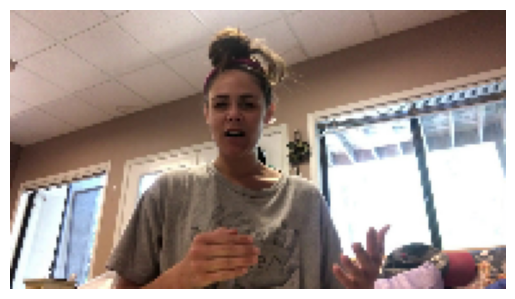

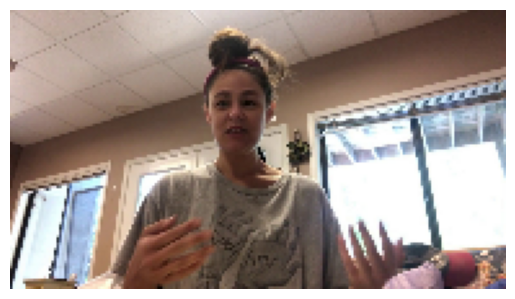

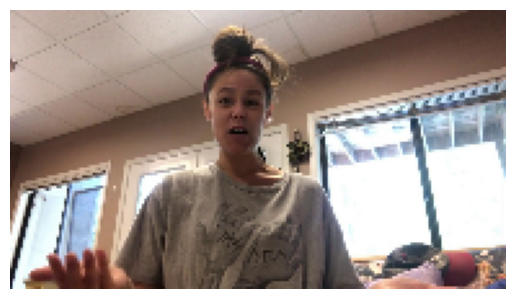

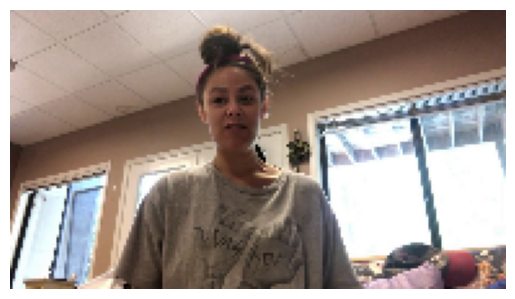

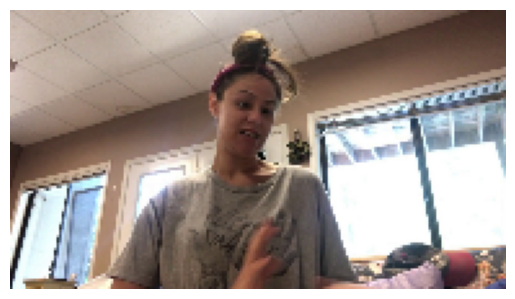

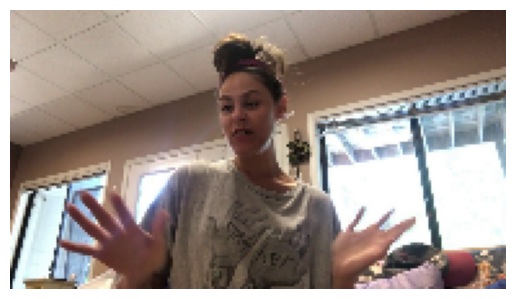

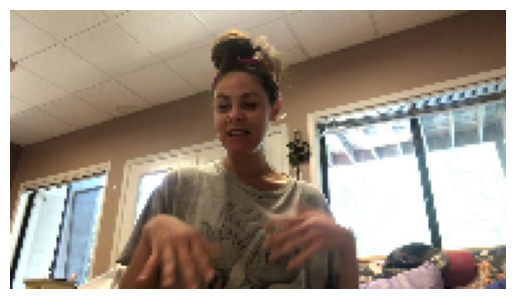

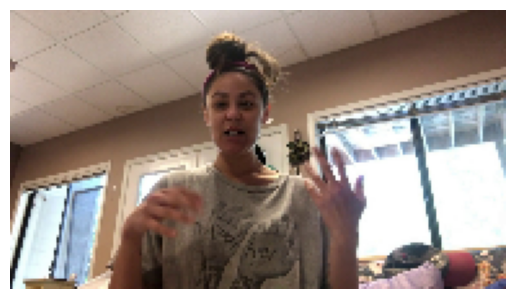

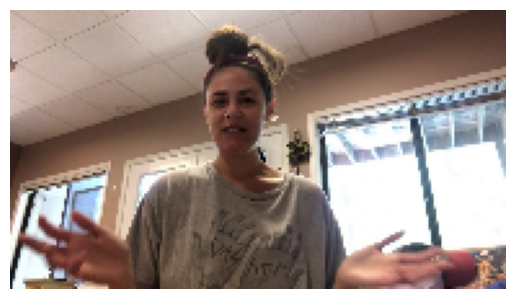

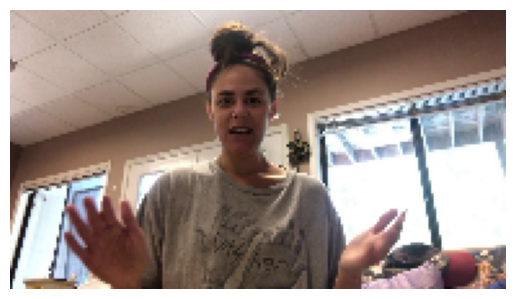

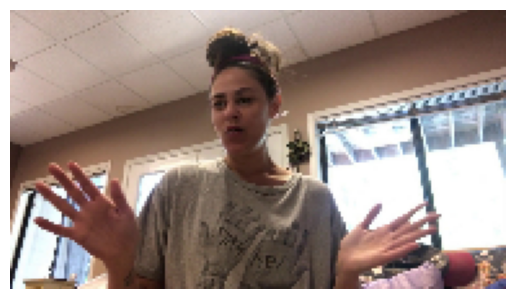

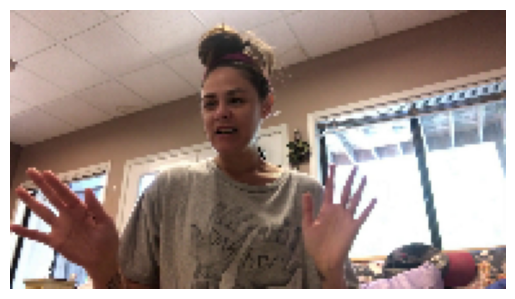

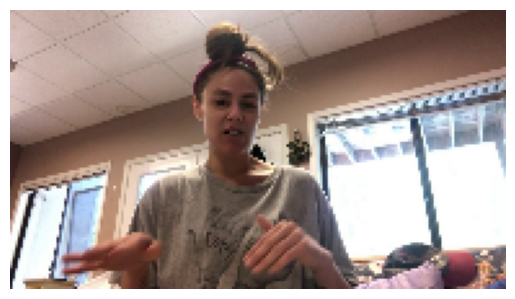

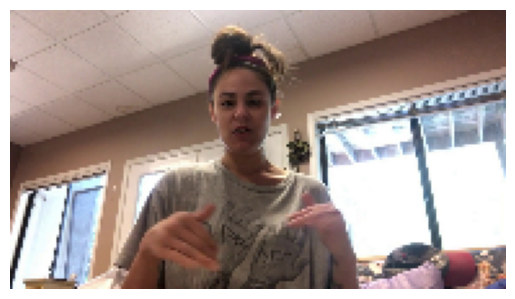

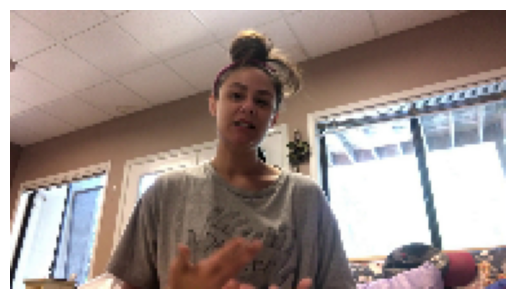

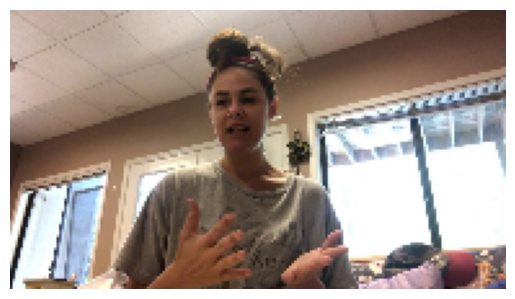

In [ ]:
#Vizualzing
image_generator = spatialX.as_numpy_iterator()
batch = image_generator.next()
count = 0
for image in batch:
  plt.imshow(image)
  plt.axis("off")
  plt.show()
  count+=1

In [ ]:
print(image.shape)

(108, 192, 3)


#MODEL ResNet50 Spatial Features

## Building Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,ResNet50V2
from tensorflow.keras.layers import Input,Dense, GlobalAveragePooling2D,Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Reshape
from tensorflow.keras.models import Model

def spatial_stream(spatial_input_shape):
  #input layer
  input_layer = Input(shape=spatial_input_shape)

  #Pretrained ResNetModel
  base_spatial = ResNet50(weights='imagenet', include_top=False,input_tensor = input_layer)
  for layer in base_spatial.layers:
    layer.trainable = False

  averageLayer = GlobalAveragePooling2D()(base_spatial.output)
  layer1 = Dense(1024, activation='relu')(averageLayer)
  layer2 = Dense(128,activation='relu')(layer1)
  model = Model(input_layer, layer2)
  return model



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# Temporal stream architecture (CNN for processing optical flow representations)
def temporal_stream(temporal_input_shape):
  #input layer
  input_layer = Input(shape=temporal_input_shape)

  #Pretrained ResNetModel
  flow_conv1 = Conv2D(128, (3, 3), activation='relu')(input_layer)
  flow_pool1 = MaxPooling2D((2, 2))(flow_conv1)
  flow_conv2 = Conv2D(64, (3, 3), activation='relu')(flow_pool1)
  flow_pool2 = MaxPooling2D((2, 2))(flow_conv2)
  flow_flat = Flatten()(flow_pool2)
  flow_fc = Dense(128, activation='relu')(flow_flat)
  model = Model(input_layer, flow_fc)
  return model

In [ ]:
def two_stream():

  spatial_input_shape = (108,192,3)
  temporal_input_shape = (108,192,2)

  spatial_model = spatial_stream(spatial_input_shape)
  temporal_model = temporal_stream((temporal_input_shape))


  combined = concatenate([spatial_model.output, temporal_model.output])
  x = Dense(256, activation='relu')(combined)
  x = Dense(256, activation='relu')(x)
  outputs = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=[spatial_model.input, temporal_model.input], outputs=outputs)
  return model

In [ ]:
model_res = two_stream()
model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_res.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 108, 192, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 114, 198, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 54, 96, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 54, 96, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Res Training

In [ ]:
for i in range(5):
  sample = next(iter(train_dataset))
  print(sample[0].shape)
  break

In [ ]:
history_res = model_res.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
660/660 [==============================] - 864s 675ms/step - loss: 0.6744 - accuracy: 0.6549 - precision_2: 0.3931 - recall_2: 0.0648 - val_loss: 0.6443 - val_accuracy: 0.6258 - val_precision_2: 0.4489 - val_recall_2: 1.0000
Epoch 2/10
660/660 [==============================] - 866s 681ms/step - loss: 0.4911 - accuracy: 0.7453 - precision_2: 0.6146 - recall_2: 0.5548 - val_loss: 0.5787 - val_accuracy: 0.5785 - val_precision_2: 0.3666 - val_recall_2: 1.0000
Epoch 3/10
660/660 [==============================] - 861s 676ms/step - loss: 0.3764 - accuracy: 0.8191 - precision_2: 0.7036 - recall_2: 0.7410 - val_loss: 0.2573 - val_accuracy: 0.8941 - val_precision_2: 0.7505 - val_recall_2: 0.9976
Epoch 4/10
660/660 [==============================] - 856s 675ms/step - loss: 0.2972 - accuracy: 0.8630 - precision_2: 0.7377 - recall_2: 0.8804 - val_loss: 0.2997 - val_accuracy: 0.8880 - val_precision_2: 0.6957 - val_recall_2: 1.0000
Epoch 5/10
660/660 [==============================] - 86

In [ ]:
model_res.save("resmodel_full.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_res.save("resmodel_full.keras")

In [ ]:
history_res_dict = history_res.history
json.dump(history_res_dict, open("training_history_full", 'w'))

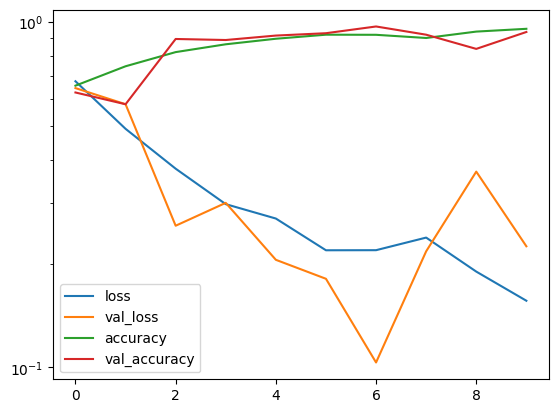

In [ ]:
history_res_df = pd.DataFrame(history_res_dict)

plt.plot(history_res_df['loss'], label='loss')
plt.plot(history_res_df['val_loss'], label='val_loss')
plt.plot(history_res_df['accuracy'], label='accuracy')
plt.plot(history_res_df['val_accuracy'], label='val_accuracy')

plt.yscale('log')
plt.legend()
plt.show()


## Res Testing

In [ ]:
model_res = tf.keras.models.load_model("/content/drive/MyDrive/CS131_Proj/Res_20_Epochs_model.h5")

OSError: No file or directory found at /content/drive/MyDrive/CS131_Proj/Res_20_Epochs_model.h5

In [ ]:
model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 216, 384, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656

In [ ]:
data = model_res.evaluate(test_dataset)
print(data)

83/83 [==============================] - 468s 31ms/step - loss: 0.0997 - accuracy: 0.9729 - precision_2: 0.9128 - recall_2: 0.9812
[0.09972328692674637, 0.9728915691375732, 0.9127907156944275, 0.981249988079071]


In [ ]:
x_test = test_dataset.map(lambda x, y: x)
y_test = test_dataset.map(lambda x, y: y)
print(x_test)
predictions = model_res.predict(test_dataset)
#Baseline Continous Predictions

<_MapDataset element_spec=(TensorSpec(shape=(None, 108, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>
60/60 [==============================] - 302s 29ms/step


In [ ]:
#print(predictions)
#Changing continuous into binary predictions

yArr = list(y_test.as_numpy_iterator())
yArr = np.array(yArr)
print(yArr)
predicted_test_res_binary = np.where(predictions > 0.5, 1.0, 0.0)
print(predicted_test_res_binary)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 

In [ ]:
yArr = yArr.flatten()
predicted_test_res_binary = predicted_test_res_binary.flatten()
print(predicted_test_res_binary.shape)
print(yArr.shape)

(960,)
(960,)


In [ ]:
#Getting Res Accuracy and Precision score:

res_test_accuracy = accuracy_score(yArr, predicted_test_res_binary)
res_test_precision = precision_score(yArr, predicted_test_res_binary)
res_test_recall = recall_score(yArr, predicted_test_res_binary)

print("Res test Accuracy: ",res_test_accuracy)
print("Res test Precision: ",res_test_precision)
print("Res test Recall: ",res_test_recall)

Res test Accuracy:  0.5260416666666666
Res test Precision:  0.36446469248291574
Res test Recall:  0.47619047619047616


In [ ]:
res_test_accuracy_fluid = accuracy_score(yArr, predictions)
res_test_precision_fluid = precision_score(yArr, predictions)
res_test_recall_fluid = recall_score(yArr, predictions)

print("Res test Accuracy: ",res_test_accuracy_fluid)
print("Res test Precision: ",res_test_precision_fluid)
print("Res test Recall: ",res_test_recall_fluid)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
print("Total Predicted Labels: ", len(predicted_test_res_binary), "Predicted \"real\" images: ", np.count_nonzero(predicted_test_res_binary))
print("Total Actual Labels: ", len(yArr), "Actual \"real\" images: ", np.count_nonzero(yArr))

Total Predicted Labels:  960 Predicted "real" images:  439
Total Actual Labels:  960 Actual "real" images:  208


In [ ]:
np.savetxt('predicted_labels_face_full.txt', predicted_test_res_binary)
np.savetxt('correct_labels_face_full.txt', yArr)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## VIDEO LOADER

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

#change if you want a diff number of frames per vid
NUM_FRAMES = 16

def extract_frames(video_path, num_frames=NUM_FRAMES):
    #print(video_path)
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(total_frames)
    frames_step = total_frames // num_frames
    frames = []
    for i in range(num_frames):
        video.set(cv2.CAP_PROP_POS_FRAMES, i*frames_step)
        success, frame = video.read()
        if success:
            frames.append(frame)
    video.release()
    return frames

def preprocess_frame(frame):
    # change frame to a tensor
    frame_tensor = tf.convert_to_tensor(frame, dtype=tf.float32)
    # resize to a fifth of the size
    size_tuple = (int(1080*(1/5)), int(1920*(1/5)))
    resized_frame = tf.image.resize(frame_tensor, size_tuple)
    #normalize
    normalized_frame = resized_frame / 255.0
    return normalized_frame

def predict_frames(frames,model):
    predictions = []
    for frame in frames:
        processed_frame = preprocess_frame(frame)
        prediction = model.predict(np.expand_dims(processed_frame, axis=0))
        predictions.append(prediction)
    #print(predictions)
    return predictions

def is_deepfake(predictions, threshold=0.8):
    # Assuming the model outputs a probability of being real
    fake_count = sum(pred > 0.5 for pred in predictions)
    # If the majority of frames are real, the video is considered not a deepfake
    return fake_count >= threshold*len(predictions)  # If not, it's considered a deepfake
#usage below
def is_deepfakeVideo(path,model):
    video_path = path
    #model_path = 'resmodel.h5'

    frames = extract_frames(video_path)
    #print(len(frames))
    predictions = predict_frames(frames, model)
    result = is_deepfake(predictions)
    return result


In [ ]:
with open('/content/drive/MyDrive/CS131_Proj/test_videos/metadata.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
labels = data.values()

In [ ]:
def read_json(path, real_only=False):
    with open(path, 'r') as file:
        data = json.load(file)
        if real_only:
            return {mp4_file: 0 for mp4_file, details in data.items() if details['label'] == 'REAL'}
        else:
            return {mp4_file: 1 if details['label'] == 'FAKE' else 1 for mp4_file, details in data.items()}

In [ ]:
path = '/content/drive/MyDrive/CS131_Proj/test_videos/metadata.json'
data = read_json(path)
labels = data.values()

In [ ]:
videoPaths = tf.data.Dataset.list_files("/content/drive/MyDrive/CS131_Proj/test_videos/*.mp4",shuffle = False)
video_paths_array = np.array(list(videoPaths.as_numpy_iterator()), dtype=str)
videoPred = []
count = 1
for path in video_paths_array:
  if count > 30:
    break
  result = is_deepfakeVideo(path,model_res)
  print("DONE: ",count)
  videoPred.append(result)
  count+=1
videoPred_arr = np.array(videoPred)

1/1 [==============================] - 0s 22ms/step
DONE:  1
1/1 [==============================] - 0s 22ms/step
DONE:  2
1/1 [==============================] - 0s 21ms/step
DONE:  3
1/1 [==============================] - 0s 21ms/step
DONE:  4
1/1 [==============================] - 0s 20ms/step
DONE:  5
1/1 [==============================] - 0s 21ms/step
DONE:  6
1/1 [==============================] - 0s 20ms/step
DONE:  7
1/1 [==============================] - 0s 20ms/step
DONE:  8
1/1 [==============================] - 0s 20ms/step
DONE:  9
1/1 [==============================] - 0s 20ms/step
DONE:  10
1/1 [==============================] - 0s 20ms/step
DONE:  11
1/1 [==============================] - 0s 20ms/step
DONE:  12
1/1 [==============================] - 0s 22ms/step
DONE:  13
1/1 [==============================] - 0s 21ms/step
DONE:  14
1/1 [==============================] - 0s 21ms/step
DONE:  15
1/1 [==============================] - 0s 21ms/step
DONE:  16
1/1 [============

In [ ]:
yArr = list(labels)[0:30]
yArr = np.array(yArr)
print(videoPred_arr)
print(yArr)

NameError: name 'videoPred_arr' is not defined

In [ ]:
vid_test_accuracy = accuracy_score(yArr, videoPred_arr)
vid_test_precision = precision_score(yArr, videoPred_arr)
vid_test_recall = recall_score(yArr, videoPred_arr)

print("Vid test Accuracy: ",vid_test_accuracy)
print("Vid test Precision: ",vid_test_precision)
print("Vid test Recall: ",vid_test_recall)

Vid test Accuracy:  0.6
Vid test Precision:  0.1111111111111111
Vid test Recall:  0.2
